In [1]:
import heeps
from heeps.util.img_processing import crop_img
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os.path

/home/oabsil/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
conf = dict(
    dirout_root = 'output_files_oab',
    band = 'L',
    apo_drift = 0.02, # (% ptv)
    f_amp = 'wavefront/cbw/20221006/talbot/LM_rep_6_-0h30.fits',
    avg = True,
    hfov = 1.5,
    ngrid = 2048,
)

In [3]:
def get_psfs(conf, outdir='', case='scao_only', modes=['APPIMG', 'APPLMS'], verbose=True):#'RAVC', 'APPIMG', 'CVC', 'CLC']):
    dirout_root = conf['dirout_root']
    conf.update(
        dir_output = os.path.join(dirout_root,outdir),
        mode = 'ELT',
        f_phase = 'wavefront/cfull/cube_Cfull_20220512_3600s_300ms_0piston_meters_%s'%case + '_L_285.fits',
    )
    conf = heeps.config.read_config(**conf)
    conf = heeps.config.update_config(**conf)
    wf = heeps.pupil.pupil(**conf, savefits=True)
    psf = heeps.wavefront.propagate(wf, **conf)
    #elt_peak = np.max(psf)
    #print('ELT peak = %.4f'%elt_peak)
    #psf /= elt_peak
    fits.writeto(conf['dir_output'] + 'onaxis_PSF_%s_ELT.fits'%conf['band'], psf, overwrite=True)
    
    for conf['mode'] in modes:
        if 'RAVC' in conf['mode']:
            conf.update(ls_dRext=0.0477, ls_dRint=0.04, ls_dRspi=0.0249)
        elif 'CVC' in conf['mode']:
            conf.update(ls_dRext=0.0209, ls_dRint=0.09, ls_dRspi=0.0245)
        elif 'CLC' in conf['mode']:
            conf.update(ls_dRext=0.1095, ls_dRint=0.0491, ls_dRspi=0.0317)
        elif 'APPIMG' in conf['mode']:
            conf.update(f_app_amp='optics/app/METIS_IMG_aper_rot.fits',
                        f_app_phase='optics/app/METIS_IMG_gvAPP_final_rot.fits')
        elif 'APPLMS' in conf['mode']:
            conf.update(f_app_amp='optics/app/METIS_LMS_aper.fits',
                        f_app_phase='optics/app/METIS_LMS_gvAPP_final.fits')
        conf = heeps.config.read_config(**conf)
        conf = heeps.config.update_config(**conf, verbose=verbose)
        wf = heeps.pupil.pupil(**conf)
        if 'VC' in conf['mode']:
            psf_OFF = heeps.wavefront.propagate(wf, onaxis=False, **conf)
            psf_ON = heeps.wavefront.propagate(wf, onaxis=True, **conf)
            print('mode = %s, leakage = %.2e'%(conf['mode'], np.sum(psf_ON)/np.sum(psf_OFF)))
        if 'APP' in conf['mode']:
            psf_ON = heeps.wavefront.propagate(wf, onaxis=True,  verbose=verbose, **conf)
            #plt.figure();plt.imshow(crop_img(np.log(psf_ON), conf['ndet'])); plt.colorbar()
            conf['mode'] += 'neg'
            psf_ON_neg = heeps.wavefront.propagate(wf, onaxis=True, verbose=False, **conf)
            #plt.figure();plt.imshow(crop_img(np.log(psf_ON_neg), conf['ndet'])); plt.colorbar()
            psf_ON += psf_ON_neg
            psf_ON /= 2
            plt.figure();plt.imshow(crop_img(np.log(psf_ON), conf['ndet'])); plt.colorbar()
        else:
            psf_ON = heeps.wavefront.propagate(wf, onaxis=True, **conf)
        #psf_ON /= elt_peak
        fits.writeto(conf['dir_output'] + 'onaxis_PSF_%s_%s.fits'%(conf['band'],conf['mode']), psf_ON, overwrite=True)

### ideal

   2024-12-20 15:45:49, e2e simulation using 56 cores
   2024-12-20 15:45:53, completed in 3.92 seconds
Simulation config: band=L, mode=APPIMG
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=571, pscale=5.4700 mas, lam=3.8045E-06 m
   hfov=1.5 arcsec (-> 70.61 lam/D)
   detector size (ndet)=549 (141.23 lam/D)

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Create on-axis PSF cube
   apply APP stop from 'METIS_IMG_aper_rot.fits'
   apply APP phase from 'METIS_IMG_gvAPP_final_rot.fits'
   2024-12-20 15:45:54, e2e simulation using 56 cores
   2024-12-20 15:45:57, completed in 3.58 seconds
Average PSF cube

   2024-12-20 15:45:58, e2e simulation using 56 cores
   2024-12-20 15:46:01, completed in 3.47 seconds
Simulation config: band=L, mode=APPLMS
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=571, pscale=5.4700 mas, lam=3.8045E-06 m
   hfov=1.5 arcsec (-> 70.61 lam/D)
   detector size (ndet)=549 (141.23 lam/D)

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Create on-axis PSF cube
   apply APP stop from 'METIS_LMS_aper.fits'
   apply APP phase from 'METIS_LMS_gvAPP_

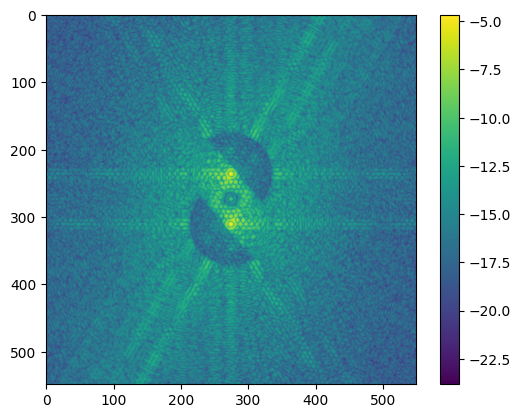

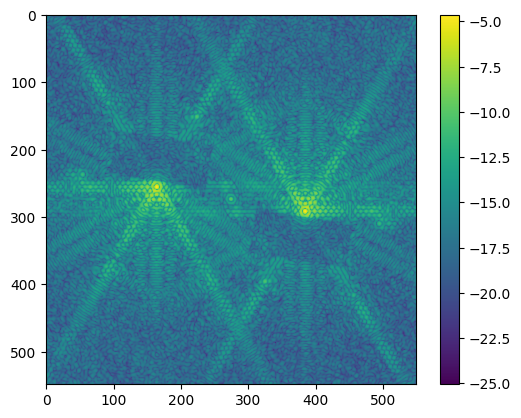

In [4]:
conf.update(
    nframes_avg = 1,
    f_pupil = 'pupil/ELT_fullM1_nov2024.fits',
    add_phase = False,
    add_apo_drift = False,
    add_amp = False,
    add_cl_vort = False,
    
)
get_psfs(conf, outdir='long_exp/ideal')

### scao only

   2024-12-20 15:46:11, e2e simulation using 56 cores
   2024-12-20 15:46:15, completed in 3.66 seconds
Simulation config: band=L, mode=APPIMG
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=571, pscale=5.4700 mas, lam=3.8045E-06 m
   hfov=1.5 arcsec (-> 70.61 lam/D)
   detector size (ndet)=549 (141.23 lam/D)

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20220512_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=1 (nframes=1, nstep=1)
Create on-axis PSF cube
   apply APP stop from 'METIS_IMG_aper_rot.fits'
   apply APP phase from 'METIS_IMG_gvAPP_final_rot.fits'
   2024-12-20 15:46:16, e2e simulation using 56 cores
   2024-12-20 15:46:20, completed in 3.68 seconds
Average PSF cube

   2024-12-20 15:46:21, e2e simulation using 56 cores
   2024-12-20 15:46:25, completed in 3.85 seconds
Simulation config: band=L, mode=APPLMS
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=571, pscale=5.4700 mas, lam=3.8045E-06 m
   hfov=1.5 arcsec (-> 70.61 lam/D)
   detector size (ndet)=549 (141.23 lam/D)

On-axis

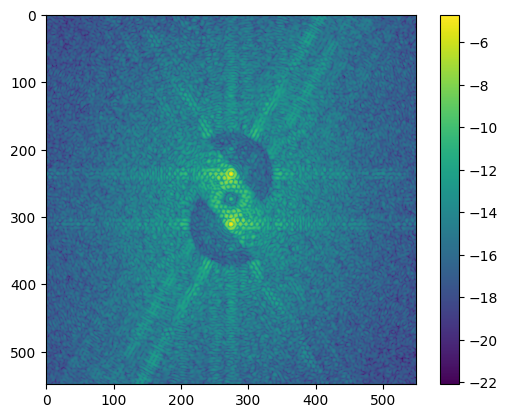

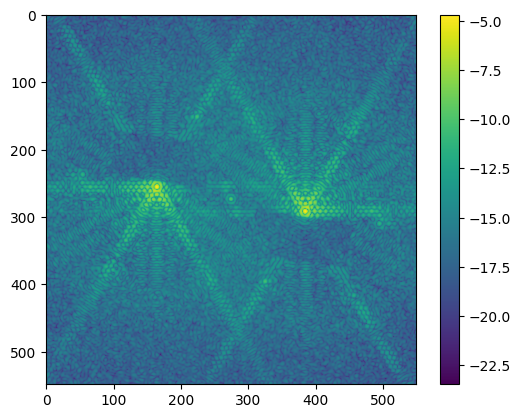

In [5]:
conf.update(
    nframes_avg = 1,
    f_pupil = 'pupil/ELT_fullM1_nov2024.fits',
    add_phase = True,
    add_apo_drift = False,
    add_amp = False,
    add_cl_vort = False,
)
get_psfs(conf, outdir='long_exp/scao_only_1frame')

### long exposure

   2024-12-20 15:46:37, e2e simulation using 56 cores
   2024-12-20 15:47:02, completed in 24.88 seconds
Simulation config: band=L, mode=APPIMG
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=571, pscale=5.4700 mas, lam=3.8045E-06 m
   hfov=1.5 arcsec (-> 70.61 lam/D)
   detector size (ndet)=549 (141.23 lam/D)

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20220512_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=100 (nframes=100, nstep=1)
Create on-axis PSF cube
   apply APP stop from 'METIS_IMG_aper_rot.fits'
   apply APP phase from 'METIS_IMG_gvAPP_final_rot.fits'
   2024-12-20 15:47:05, e2e simulation using 56 cores
   2024-12-20 15:47:32, completed in 27.45 seconds
Average PSF cube

   2024-12-20 15:47:34, e2e simulation using 56 cores
   2024-12-20 15:48:02, completed in 27.19 seconds
Simulation config: band=L, mode=APPLMS
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=571, pscale=5.4700 mas, lam=3.8045E-06 m
   hfov=1.5 arcsec (-> 70.61 lam/D)
   detector size (ndet)=549 (141.23 lam/D)



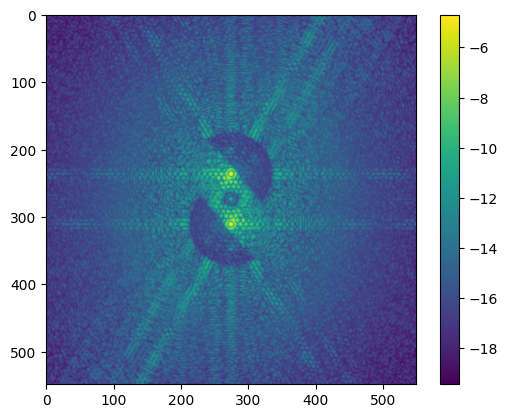

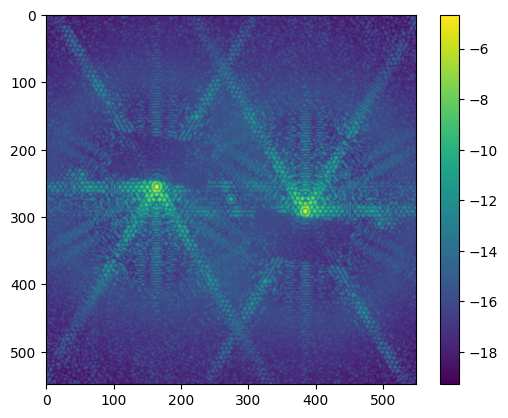

In [6]:
conf.update(
    nframes_avg = 100,
    f_pupil = 'pupil/ELT_fullM1_nov2024.fits',
    add_phase = True,
    add_apo_drift = False,
    add_amp = False,
    add_cl_vort = False,
)
get_psfs(conf, outdir='long_exp/scao_only')

   2024-12-20 15:49:10, e2e simulation using 56 cores
   2024-12-20 15:49:39, completed in 28.56 seconds
Simulation config: band=L, mode=APPIMG
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=571, pscale=5.4700 mas, lam=3.8045E-06 m
   hfov=1.5 arcsec (-> 70.61 lam/D)
   detector size (ndet)=549 (141.23 lam/D)

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20220512_3600s_300ms_0piston_meters_all_ncpa_L_285.fits'
   nscreens=100 (nframes=100, nstep=1)
Load amp screens from 'LM_rep_6_-0h30.fits'
   nscreens=100
Create on-axis PSF cube
   amplitude screen not preloaded: len(amp_screens)=100
   apply APP stop from 'METIS_IMG_aper_rot.fits'
   apply APP phase from 'METIS_IMG_gvAPP_final_rot.fits'
   2024-12-20 15:49:47, e2e simulation using 56 cores
   2024-12-20 15:50:15, completed in 27.84 seconds
Average PSF cube

   2024-12-20 15:50:25, e2e simulation using 56 cores
   2024-12-20 15:50:53, completed in 28.02 seconds
Simulation config: band=L, mode=APPLMS
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=571, p

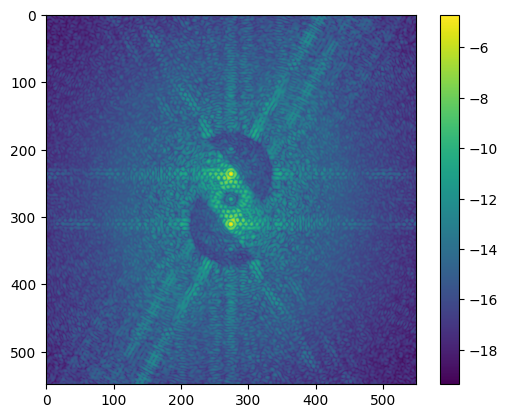

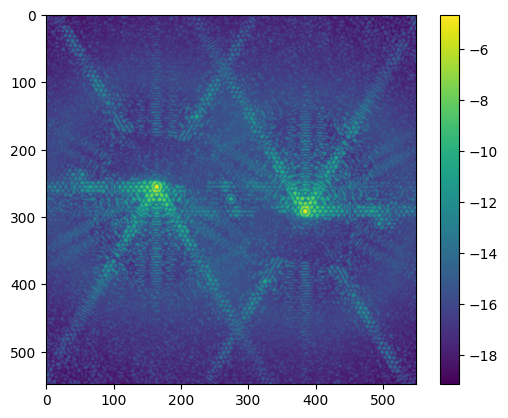

In [7]:
conf.update(
    nframes_avg = 100,
    f_pupil = 'pupil/ELT_fullM1_nov2024_refl_0.10ptv.fits',
    add_phase = True,
    add_apo_drift = True,
    add_amp = True,
    add_cl_vort = True,
)
get_psfs(conf, outdir='long_exp/all_effects', case='all_ncpa')#, modes=['RAVC'])

   2024-12-20 15:52:16, e2e simulation using 56 cores
   2024-12-20 15:52:42, completed in 26.7 seconds
Simulation config: band=L, mode=APPIMG
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=571, pscale=5.4700 mas, lam=3.8045E-06 m
   hfov=1.5 arcsec (-> 70.61 lam/D)
   detector size (ndet)=549 (141.23 lam/D)

On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20220512_3600s_300ms_0piston_meters_all_ncpa_L_285.fits'
   nscreens=100 (nframes=100, nstep=1)
Load amp screens from 'LM_rep_6_-0h30.fits'
   nscreens=100
Create on-axis PSF cube
   amplitude screen not preloaded: len(amp_screens)=100
   apply APP stop from 'METIS_IMG_aper_rot.fits'
   apply APP phase from 'METIS_IMG_gvAPP_final_rot.fits'
   2024-12-20 15:52:52, e2e simulation using 56 cores
   2024-12-20 15:53:19, completed in 27.1 seconds
Average PSF cube

   2024-12-20 15:53:28, e2e simulation using 56 cores
   2024-12-20 15:53:55, completed in 26.93 seconds
Simulation config: band=L, mode=APPLMS
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=571, psc

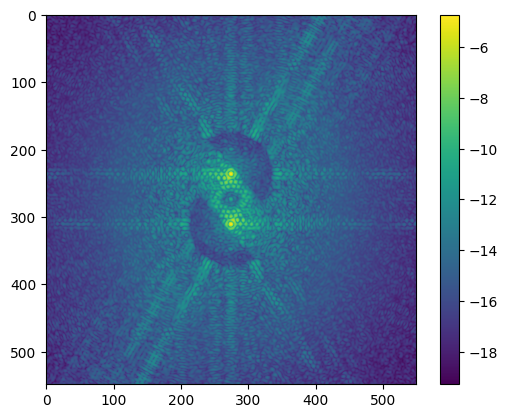

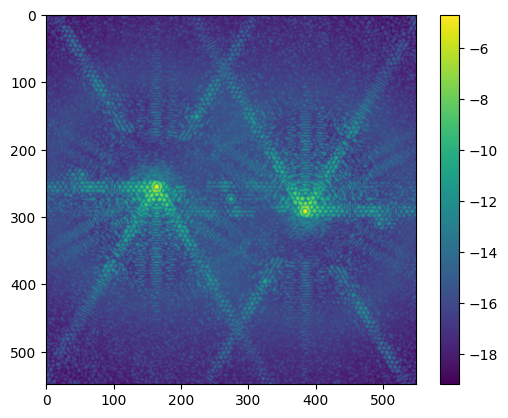

In [8]:
conf.update(
    nframes_avg = 100,
    f_pupil = 'pupil/ELT_fullM1_nov2024_refl_0.10ptv_misseg_1x7.fits',
    add_phase = True,
    add_apo_drift = True,
    add_amp = True,
    add_cl_vort = True,
)
get_psfs(conf, outdir='long_exp/all_effects_misseg', case='all_ncpa')#, modes=['RAVC'])